In [ ]:
# Import Libraries

import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import kagglehub

In [7]:
# 1. Download & Locate FERAC Dataset

path = kagglehub.dataset_download("rajasreechaiti/ferac-dataset")
print("Base dataset path:", path)

image_path = None
for root, dirs, files in os.walk(path):
    for d in dirs:
        if "ferac" in d.lower() or "image" in d.lower():
            image_path = os.path.join(root, d)
            break
    if image_path:
        break

if not image_path:
    raise FileNotFoundError("No image folder found in FERAC dataset!")

print("✅ Found image folder:", image_path)
classes = os.listdir(image_path)
print("Emotion Classes:", classes)

Base dataset path: /kaggle/input/ferac-dataset
✅ Found image folder: /kaggle/input/ferac-dataset/FERAC Dataset
Emotion Classes: ['test', 'train']


In [8]:
# 2. Data Generators

img_size = (64, 64)

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    image_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    image_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 616 images belonging to 2 classes.
Found 154 images belonging to 2 classes.


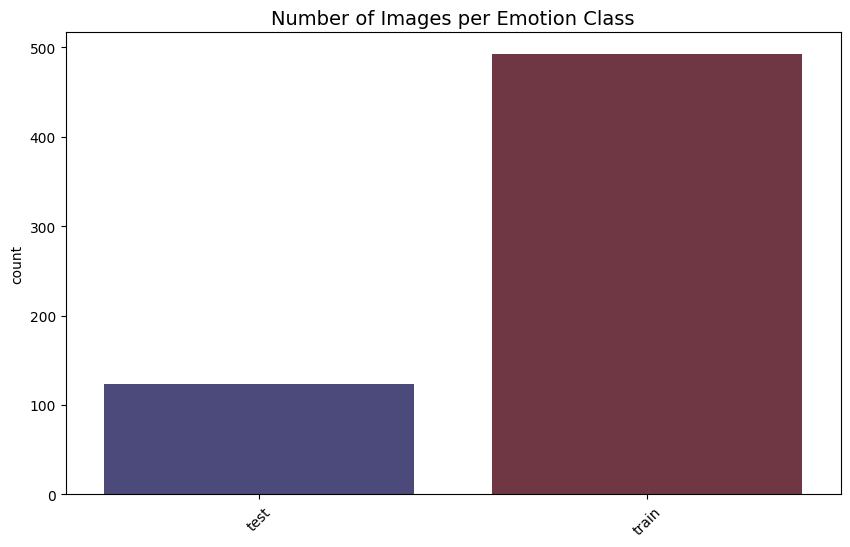

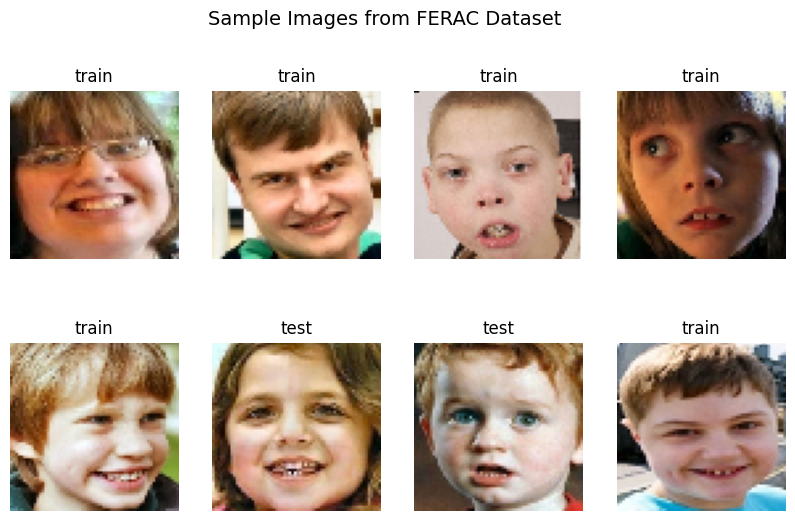

In [9]:
# 3. Data Visualization


# Class distribution plot
plt.figure(figsize=(10, 6))
sns.countplot(x=[classes[label] for label in train_gen.classes], palette="icefire")
plt.title("Number of Images per Emotion Class", fontsize=14)
plt.xticks(rotation=45)
plt.show()

# Show multiple sample images
sample_img, sample_label = next(train_gen)
plt.figure(figsize=(10, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(sample_img[i])
    plt.title(classes[np.argmax(sample_label[i])])
    plt.axis("off")
plt.suptitle("Sample Images from FERAC Dataset", fontsize=14)
plt.show()

In [10]:
# 4. Build CNN Model

model = Sequential()
model.add(Conv2D(filters=8, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(img_size[0], img_size[1], 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(train_gen.num_classes, activation="softmax"))

# Compile
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [15]:
# 5. Train Model

epochs = 20
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen
)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.8014 - loss: 0.5133 - val_accuracy: 0.7987 - val_loss: 0.5437
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.8156 - loss: 0.4749 - val_accuracy: 0.7987 - val_loss: 0.5541
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.8021 - loss: 0.4814 - val_accuracy: 0.7987 - val_loss: 0.5321
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.7980 - loss: 0.4850 - val_accuracy: 0.7987 - val_loss: 0.5404
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.8069 - loss: 0.4789 - val_accuracy: 0.7987 - val_loss: 0.5209
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.8047 - loss: 0.4610 - val_accuracy: 0.7987 - val_loss: 0.5168
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 218ms/step - accuracy: 0.8199 - loss: 0.4386 - val_accuracy: 0.7987 - val_loss: 0.5208
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.7956 - loss: 0.4468 - val_accuracy: 0.

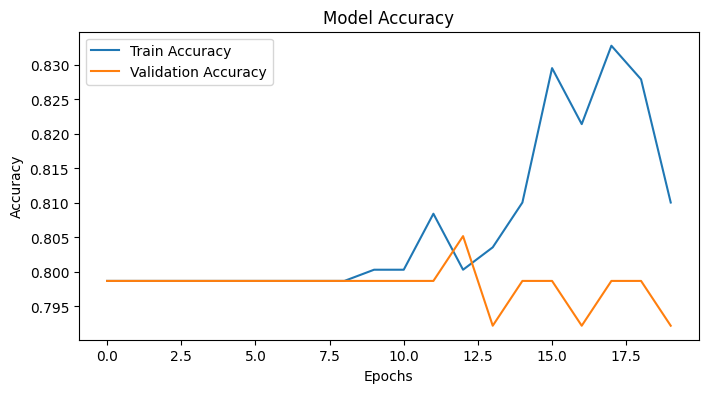

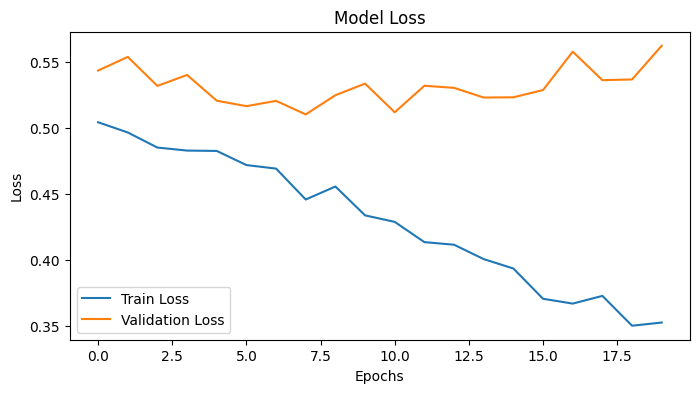

In [16]:
# 6. Accuracy & Loss Plots

plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step


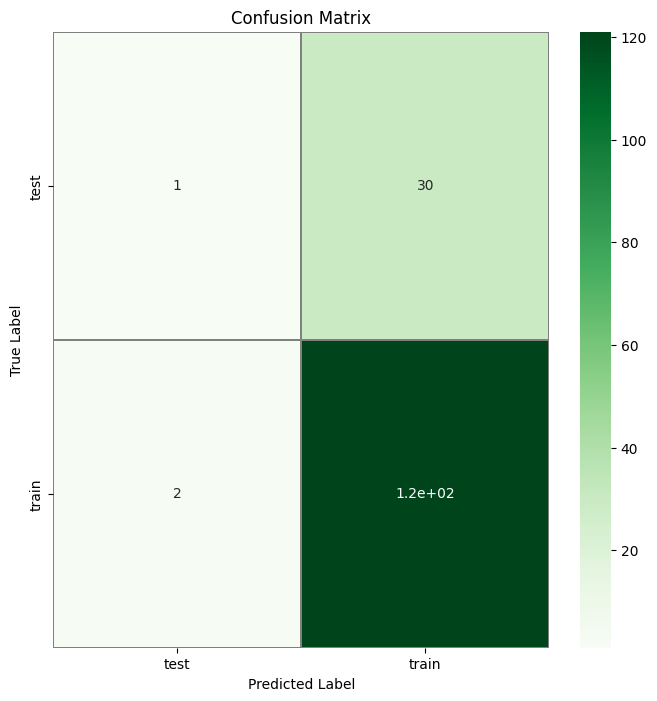

In [17]:
# 7. Confusion Matrix

Y_pred = model.predict(val_gen)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = val_gen.classes
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [20]:
history.history['accuracy'][-1]   # training accuracy
history.history['val_accuracy'][-1]  # validation accuracy

0.7922077775001526